In [14]:
import pandas as pd
import numpy as np
import spacy
import scispacy
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import LSTM, Dense,Dropout, Embedding, Dense, Flatten, BatchNormalization
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

In [15]:
# !pip install scispacy
# !pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.5.3/en_core_sci_sm-0.5.3.tar.gz

In [16]:
# Load the SciSpaCy model
nlp = spacy.load("en_core_sci_sm")

In [17]:
# Read CSV file
df = pd.read_csv('data.csv')
df = df.dropna(subset=['text', 'label']) # Remove all rows with missing values
df['text'] = df['text'].str.replace(r'[^\w\s]+', '', regex=True) # Remove all punctuation
df['text'] = df['text'].str.encode('ascii', 'ignore').str.decode('ascii') # Remove all non-ASCII chars
df['label'] = df['label'].str.lower()

In [18]:
# Preprocess text and extract features
def preprocess_text(text):
    doc = nlp(text)
    lemmatized_tokens = [token.lemma_ for token in doc if not token.is_stop and token.is_alpha]
    preprocessed_text = ' '.join(lemmatized_tokens)
    return preprocessed_text

df['text'] = df['text'].apply(preprocess_text)

In [19]:
df['text']

0       need add water drug vaccine ready administer p...
1       Hydroxychloroquine show effective rate treat D...
2       Fact Hydroxychloroquine show effective rate tr...
3       Corona virus man virus create Wuhan laboratory...
4       not billgates finance research Wuhan lab Coron...
                              ...                        
1159    study suggest ultraviolet ray slow virus wipe ...
1160    week medical journal report business traveler ...
1161    new report send White House science adviser sa...
1162    vaccine ultimate weapon coronavirus good route...
1163    develop deliver coronavirus vaccine test treat...
Name: text, Length: 1151, dtype: object

In [20]:
# Encode labels
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['label'])

In [21]:
# Split data into train, test, and validation sets
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['label'], test_size=0.25, random_state=42)
# X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5, random_state=42)  

In [22]:
# Tokenize text
tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
# X_val = tokenizer.texts_to_sequences(X_val)
X_test = tokenizer.texts_to_sequences(X_test)

# Pad sequences
max_len = max(len(seq) for seq in X_train)
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, maxlen=max_len)
# X_val = tf.keras.preprocessing.sequence.pad_sequences(X_val, maxlen=max_len)
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, maxlen=max_len)


In [23]:
# Define the model architecture
model = Sequential([
    Embedding(input_dim=len(tokenizer.word_index)+1, output_dim=100, input_length=max_len),
    LSTM(units=25),
    Dropout(0.5),
    BatchNormalization(),
    Dense(10, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/50
27/27 [==============================] - 27s 794ms/step - loss: 0.6476 - accuracy: 0.6153 - val_loss: 0.6854 - val_accuracy: 0.5139
Epoch 2/50
27/27 [==============================] - 19s 705ms/step - loss: 0.3706 - accuracy: 0.8899 - val_loss: 0.5854 - val_accuracy: 0.8542
Epoch 3/50
27/27 [==============================] - 19s 702ms/step - loss: 0.1518 - accuracy: 0.9745 - val_loss: 0.4867 - val_accuracy: 0.8646
Epoch 4/50
27/27 [==============================] - 19s 709ms/step - loss: 0.0747 - accuracy: 0.9907 - val_loss: 0.4142 - val_accuracy: 0.8958
Epoch 5/50
27/27 [==============================] - 19s 712ms/step - loss: 0.0437 - accuracy: 0.9977 - val_loss: 0.3852 - val_accuracy: 0.8750
Epoch 6/50
27/27 [==============================] - 19s 709ms/step - loss: 0.0305 - accuracy: 0.9977 - val_loss: 0.3261 - val_accuracy: 0.8785
Epoch 7/50
27/27 [==============================] - 19s 699ms/step - loss: 0.0191 - accuracy: 0.9977 - val_loss: 0.3516 - val_accuracy: 0.8681

In [24]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print("Loss:", loss)
print("Accuracy:", accuracy)

9/9 [==============================] - 1s 109ms/step - loss: 0.9637 - accuracy: 0.8715
Loss: 0.9636711478233337
Accuracy: 0.8715277910232544


In [25]:
# Predict labels
y_pred_probs = model.predict(X_test)
y_pred_labels = (y_pred_probs > 0.5).astype(int)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred_labels)
precision = precision_score(y_test, y_pred_labels)
recall = recall_score(y_test, y_pred_labels)
f1 = f1_score(y_test, y_pred_labels)
auc = roc_auc_score(y_test, y_pred_labels)


print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("AUC Score:", auc)

9/9 [==============================] - 1s 109ms/step
Accuracy: 0.8715277777777778
Precision: 0.9019607843137255
Recall: 0.8625
F1 Score: 0.8817891373801917
AUC Score: 0.87265625


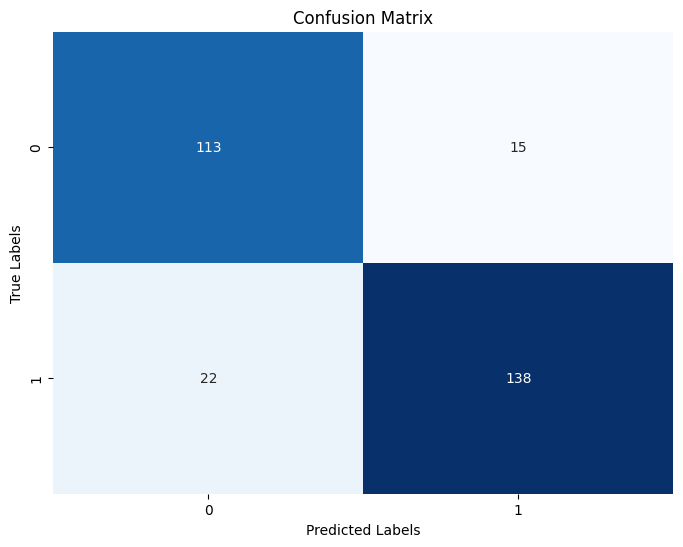

In [26]:
# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()